In [25]:
# Fixing up integration and then subclustering

import scanpy as sc
import anndata as ad
import pandas as pd
from scipy.sparse import csr_matrix, vstack
import random
import numpy as np
import random
from scipy.io import mmread, mmwrite
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt

This code loads the AnnData object from the H5AD file "scanorama_full_leiden_v1.h5ad" into the variable adata. This allows access to the data with Leiden clustering results and any associated metadata for further analysis.

In [26]:
# Load the H5AD file into an AnnData object
adata = ad.read_h5ad('D:/newgenes/data/scanorama_full_leiden_v1.h5ad')

This code plots a UMAP visualization of cells from cluster 21 (based on the Leiden clustering) in the adata object. It colors the points by the "Main_cluster_name" and "origin" columns, with a specified space between subplots (wspace=0.7), suggesting a focus on subclustering within cluster 21.

c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-pa

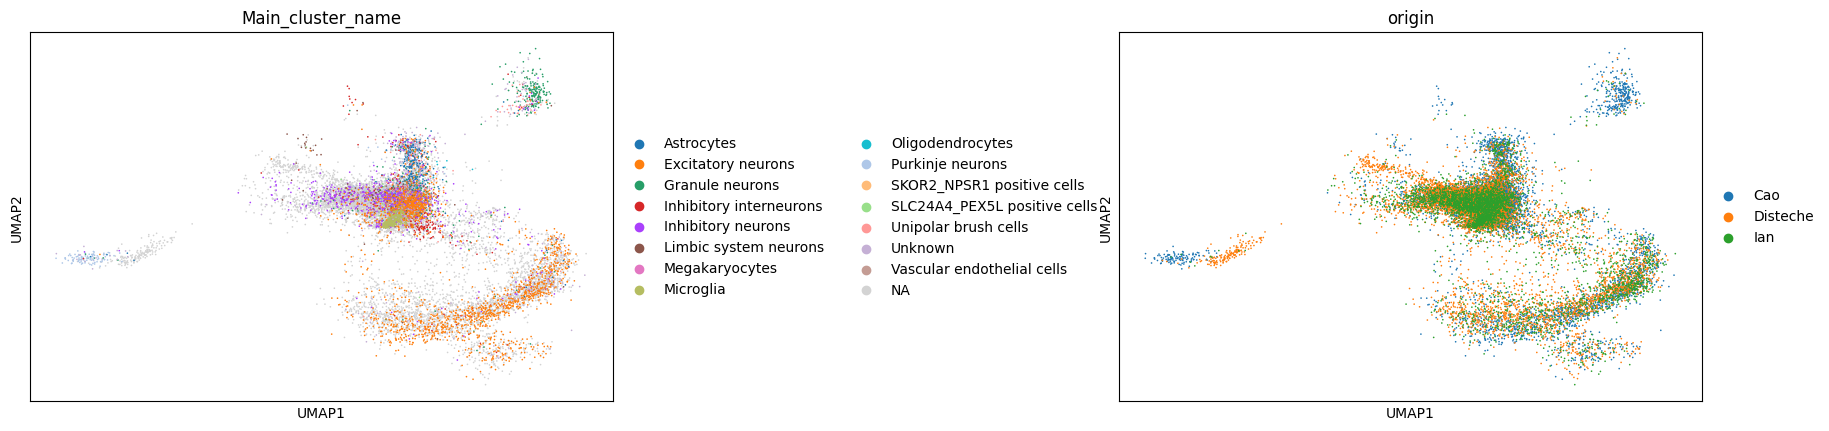

In [28]:
# Cluster 21 - looks like we can subcluster
sc.pl.umap(adata[adata.obs["leiden"] == "21"], color = ["Main_cluster_name", "origin"], wspace=0.7)

This code subsets the adata object to include only the cells from cluster 21, creating adata_21. It then changes the "leiden" column to an integer type and re-applies the Leiden clustering algorithm to adata_21 with a resolution of 1, which may result in further subclustering within cluster 21.

In [29]:
adata_21 = adata[adata.obs["leiden"] == "21"]
adata_21.obs["leiden"] = adata_21.obs["leiden"].astype(int)
sc.tl.leiden(adata_21, resolution = 1)


c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\2518283218.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_21.obs["leiden"] = adata_21.obs["leiden"].astype(int)


This code processes cao_obs_21 (a subset of adata_21 containing cells from the "Cao" origin) by:

    Grouping the data by 'leiden' and 'Main_cluster_name' and counting the number of rows in each group.
    Calculating the total count of cells for each 'leiden' value.
    Computing the percentage of each 'Main_cluster_name' group within each 'leiden' cluster based on the total counts, storing the result in the percentage column.

In [30]:
cao_obs_21 = adata_21.obs[adata.obs['origin'] == "Cao"]
cao_obs_21["leiden"] = cao_obs_21["leiden"].astype(int)

# Step 1: Group by 'leiden' and 'Main_cluster_name', and count rows
counts_21 = cao_obs_21.groupby(['leiden', 'Main_cluster_name']).size().reset_index(name='count')
counts_21["leiden"] = counts_21["leiden"].astype(int)
# Step 2: Calculate total counts per leiden value
total_counts_21 = cao_obs_21.groupby('leiden').size()

# Step 3: Compute percentages
counts_21['total_rows'] = counts_21['leiden'].map(total_counts_21)  # Map total counts to each row
counts_21['percentage'] = (counts_21['count'] / counts_21['total_rows']) * 100

C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\2981074251.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cao_obs_21 = adata_21.obs[adata.obs['origin'] == "Cao"]
C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\2981074251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cao_obs_21["leiden"] = cao_obs_21["leiden"].astype(int)
C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\2981074251.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_21 = cao_obs_21.groupby(['leiden', 'Main_cluster_name']).size().rese

This code processes non_cao_21 (a subset of adata_21 containing cells where the origin is not "Cao") by:

    Grouping the data by 'leiden' and counting the number of rows in each group.
    Storing the resulting counts in the counts_21_uw DataFrame, with the 'leiden' column cast to integers.

This prepares the data for further analysis or visualization, focusing on the non-"Cao" cells within cluster 21.

In [31]:
non_cao_21 = adata_21.obs[adata.obs['origin'] != "Cao"]
non_cao_21["leiden"] = non_cao_21["leiden"].astype(int)

# Step 1: Group by 'leiden' and 'Main_cluster_name', and count rows
counts_21_uw = non_cao_21.groupby(['leiden']).size().reset_index(name='count')
counts_21_uw["leiden"] = counts_21_uw["leiden"].astype(int)

C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\288546725.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_cao_21 = adata_21.obs[adata.obs['origin'] != "Cao"]
C:\Users\Elliott\AppData\Local\Temp\ipykernel_26724\288546725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_cao_21["leiden"] = non_cao_21["leiden"].astype(int)


This code creates a subset of adata_21 called non_mg_adata, which includes all cells from adata_21 that do not belong to cluster 21 (based on the "leiden" column). This allows for further analysis on cells outside of cluster 21 while preserving the other clusters in the data.

In [42]:
# different method where you just change leiden id on the main adata object for the one cluster you want

non_mg_adata = adata_21[adata_21.obs["leiden"] != "21"]

c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


This code extracts the indices of the cells in non_mg_adata and stores them as a list in the variable ind_to_remove. These indices represent the cells that are outside of cluster 21 and can be used for further processing, such as removing them from another dataset.

In [44]:
ind_to_remove = non_mg_adata.obs.index.values.tolist()

This code creates a new AnnData object, adata_filtered, by removing the cells with indices in ind_to_remove from the original adata object. The ~ operator is used to filter out (exclude) these cells, retaining only the cells that are not in ind_to_remove.

In [50]:
adata_filtered = adata[~adata.obs.index.isin(ind_to_remove)]

c:\Users\Elliott\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [ ]:
# ------------ Below creates BDRL_Sample_ID, age, genotype

This code performs several data manipulations on the bdrl_bbi_labels DataFrame and merges it with adata_filtered.obs:

    It creates a duplicate of bdrl_bbi_labels with modified BAT Sample ID values (appending 'b') and then appends the duplicated rows to the original DataFrame.
    It performs a left join with adata_filtered.obs, matching on the sampleID and BAT Sample ID columns.
    The 'BAT Sample ID' column is dropped, and any missing values in the 'BDRL_Sample_ID' column are filled with a default value ('H27058 000 day_F_GG').
    It extracts age from the 'BDRL_Sample_ID' column and assigns it as an integer, and extracts genotype from the last part of 'BDRL_Sample_ID' (splitting by '_').
    It replaces specific values (0, 'GG', and 'H27058 000 day_F_GG') with NaN in the age, genotype, and 'BDRL_Sample_ID' columns for cleaning.

In [53]:
bdrl_bbi_labels = pd.read_csv("D:/newgenes/data/BDRL_BBI_dis.csv")

# Create a duplicate of the DataFrame with modified BDRL_label
duplicated_bbi_labels = bdrl_bbi_labels.copy()
duplicated_bbi_labels['BAT Sample ID'] = duplicated_bbi_labels['BAT Sample ID'] + 'b'

# Append the duplicated rows to the original DataFrame
result = pd.concat([bdrl_bbi_labels, duplicated_bbi_labels], ignore_index=True)
# Perform the left join
obs_hold = pd.merge(adata_filtered.obs, result, how='left', left_on='sampleID', right_on='BAT Sample ID')
obs_hold.index = adata_filtered.obs.index

# Drop the BDRL_label column if it is no longer needed
obs_hold.drop(columns=['BAT Sample ID'], inplace=True)

# Replace NaN values in 'sampleID' column with 'test123'
obs_hold['BDRL_Sample_ID'] = obs_hold['BDRL_Sample_ID'].fillna('H27058 000 day_F_GG')

# Extract age from SampleID
obs_hold['age'] = obs_hold['BDRL_Sample_ID'].str.extract(r'(\d+) day')[0].astype(int)

# Extract genotype from SampleID
obs_hold['genotype'] = obs_hold['BDRL_Sample_ID'].str.split('_').str[-1]


# Replace 0 with NaN in the 'age' column
obs_hold['age'] = obs_hold['age'].replace(0, np.nan)

# Replace GG with NaN in the 'age' column
obs_hold['genotype'] = obs_hold['genotype'].replace('GG', np.nan)

# Replace fake sampleID with NaN in the 'age' column
obs_hold['BDRL_Sample_ID'] = obs_hold['BDRL_Sample_ID'].replace('H27058 000 day_F_GG', np.nan)

This code performs several operations to clean and modify the obs_hold DataFrame, which will later be assigned to adata_filtered.obs:

    It creates a new merged column by combining the 'genotype' and 'sex' columns, filling missing values in 'genotype' with 'sex' values (replacing 'M' with 'XY' and 'F' with 'XX').
    It creates a merged_two column to fill any remaining missing values in 'merged' using values from 'Sex' (replacing 'M' with 'XY' and 'F' with 'XX').
    The 'genotype' column is updated with the values from 'merged_two', and the temporary merged and merged_two columns are dropped.
    A similar process is applied to the age column, first filling in missing values with 'Development_day' and then with 'day', with the final result stored in 'age'. Again, the temporary columns are removed.
    The 'genotype' column is converted to a categorical type for efficient storage and processing.
    The obs_hold DataFrame is assigned to adata_filtered.obs, and the 'leiden' column is converted to integers.

This prepares the adata_filtered object for further analysis with cleaned and updated metadata.

In [54]:
# Create a new column 'merged' based on 'sex' and 'genotype'
obs_hold['merged'] = obs_hold['genotype'].fillna(obs_hold['sex'].replace({'M': 'XY', 'F': 'XX'}))
obs_hold['merged_two'] = obs_hold['merged'].fillna(obs_hold['Sex'].replace({'M': 'XY', 'F': 'XX'}))
obs_hold['genotype'] = obs_hold['merged_two']

# Drop the BDRL_label column if it is no longer needed
obs_hold.drop(columns=['merged'], inplace=True)
obs_hold.drop(columns=['merged_two'], inplace=True)

obs_hold['merged'] = obs_hold['age'].fillna(obs_hold['Development_day'])
obs_hold['merged_two'] = obs_hold['merged'].fillna(obs_hold['day'])
obs_hold['age'] = obs_hold['merged_two']

obs_hold.drop(columns=['merged'], inplace=True)
obs_hold.drop(columns=['merged_two'], inplace=True)

# Convert the column to categorical type
obs_hold['genotype'] = obs_hold['genotype'].astype('category')

adata_filtered.obs = obs_hold

adata_filtered.obs["leiden"] = adata_filtered.obs["leiden"].astype(int)

This code saves the adata_filtered AnnData object, with the updated metadata, to an H5AD file named "scanorama_full_leiden_v2.h5ad". This file now contains the processed data, including the cleaned and modified observation metadata, ready for future analysis.

In [59]:
adata_filtered.write_h5ad("D:/newgenes/data/scanorama_full_leiden_v2.h5ad")